In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.datasets import make_classification

In [3]:
course_review = pd.read_csv('Data/Coursera_reviews.csv')
coursera_courses = pd.read_csv('Data/coursera_courses.csv')


In [10]:
coursera_courses.shape, course_review.shape

((623, 4), (1454711, 5))

In [6]:
coursera_courses.head()

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being
3,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals
4,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,google-cbrs-cpi-training


In [5]:
course_review.head()

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [8]:
combined_data = pd.merge(coursera_courses, course_review, on='course_id', how='inner')

combined_data.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,"Nov 09, 2015",1
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,"Apr 15, 2019",1
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,"Sep 25, 2015",1
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,"Dec 12, 2015",1


In [9]:
# Let's get the range of the dates
combined_data['date_reviews'] = pd.to_datetime(combined_data['date_reviews'], errors='coerce')

date_min = combined_data['date_reviews'].min()
date_max = combined_data['date_reviews'].max()

print("Date Range of Reviews:")
print("Earliest Review Date:", date_min)
print("Latest Review Date:", date_max)


Date Range of Reviews:
Earliest Review Date: 2015-08-07 00:00:00
Latest Review Date: 2020-10-10 00:00:00


<Axes: >

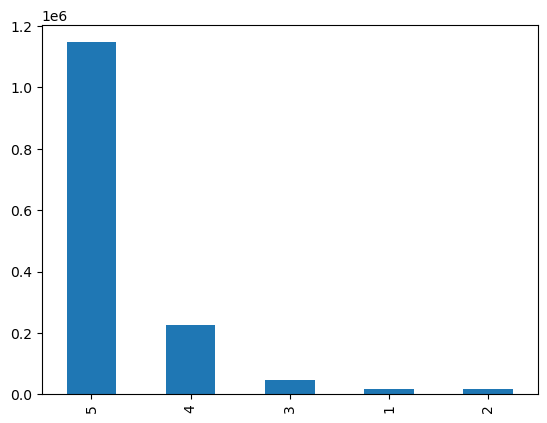

In [12]:
combined_data['rating'].value_counts().plot(kind='bar')

In [13]:
combined_data['rating'].value_counts()

5    1146164
4     226702
3      48303
1      17354
2      16188
Name: rating, dtype: int64

In [22]:
df = combined_data[['rating','reviews']]

In [23]:
df.isna().sum()

rating       0
reviews    140
dtype: int64

In [24]:
df.duplicated().sum()

993564

In [25]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

/var/folders/mj/rwsfcy551jd8ltwbtw8d_bz00000gn/T/ipykernel_26797/444993789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
/var/folders/mj/rwsfcy551jd8ltwbtw8d_bz00000gn/T/ipykernel_26797/444993789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [26]:
df.duplicated().sum(),df.isna().sum()

(0,
 rating     0
 reviews    0
 dtype: int64)

In [27]:
df['rating'].value_counts()

5    356175
4     75311
3     17212
1      6445
2      5999
Name: rating, dtype: int64

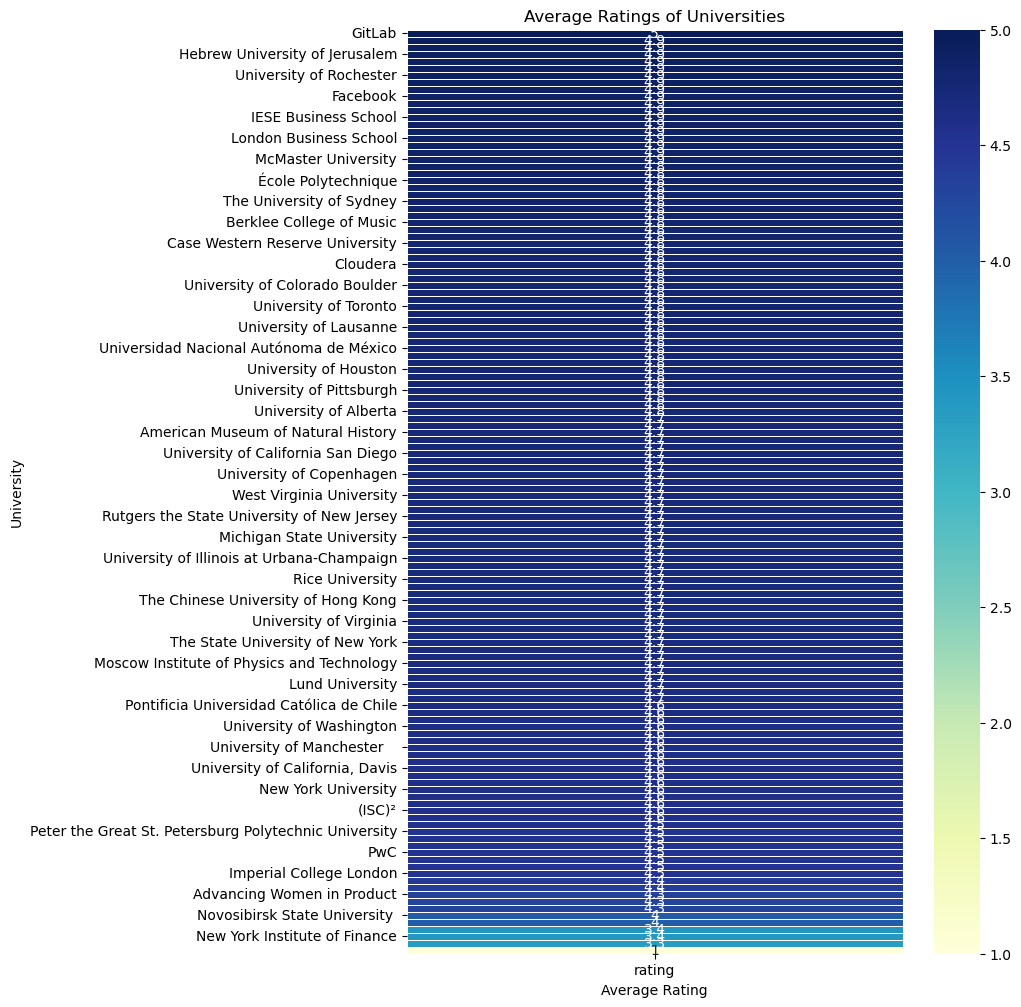

In [29]:
# Let's see what the distribution of universities looks like

university_ratings = combined_data.groupby('institution')['rating'].mean().sort_values(ascending=False)

heatmap_data = pd.DataFrame(university_ratings)

plt.figure(figsize=(8, 12))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5)

plt.title("Average Ratings of Universities")
plt.xlabel("Average Rating")
plt.ylabel("University")
plt.show()

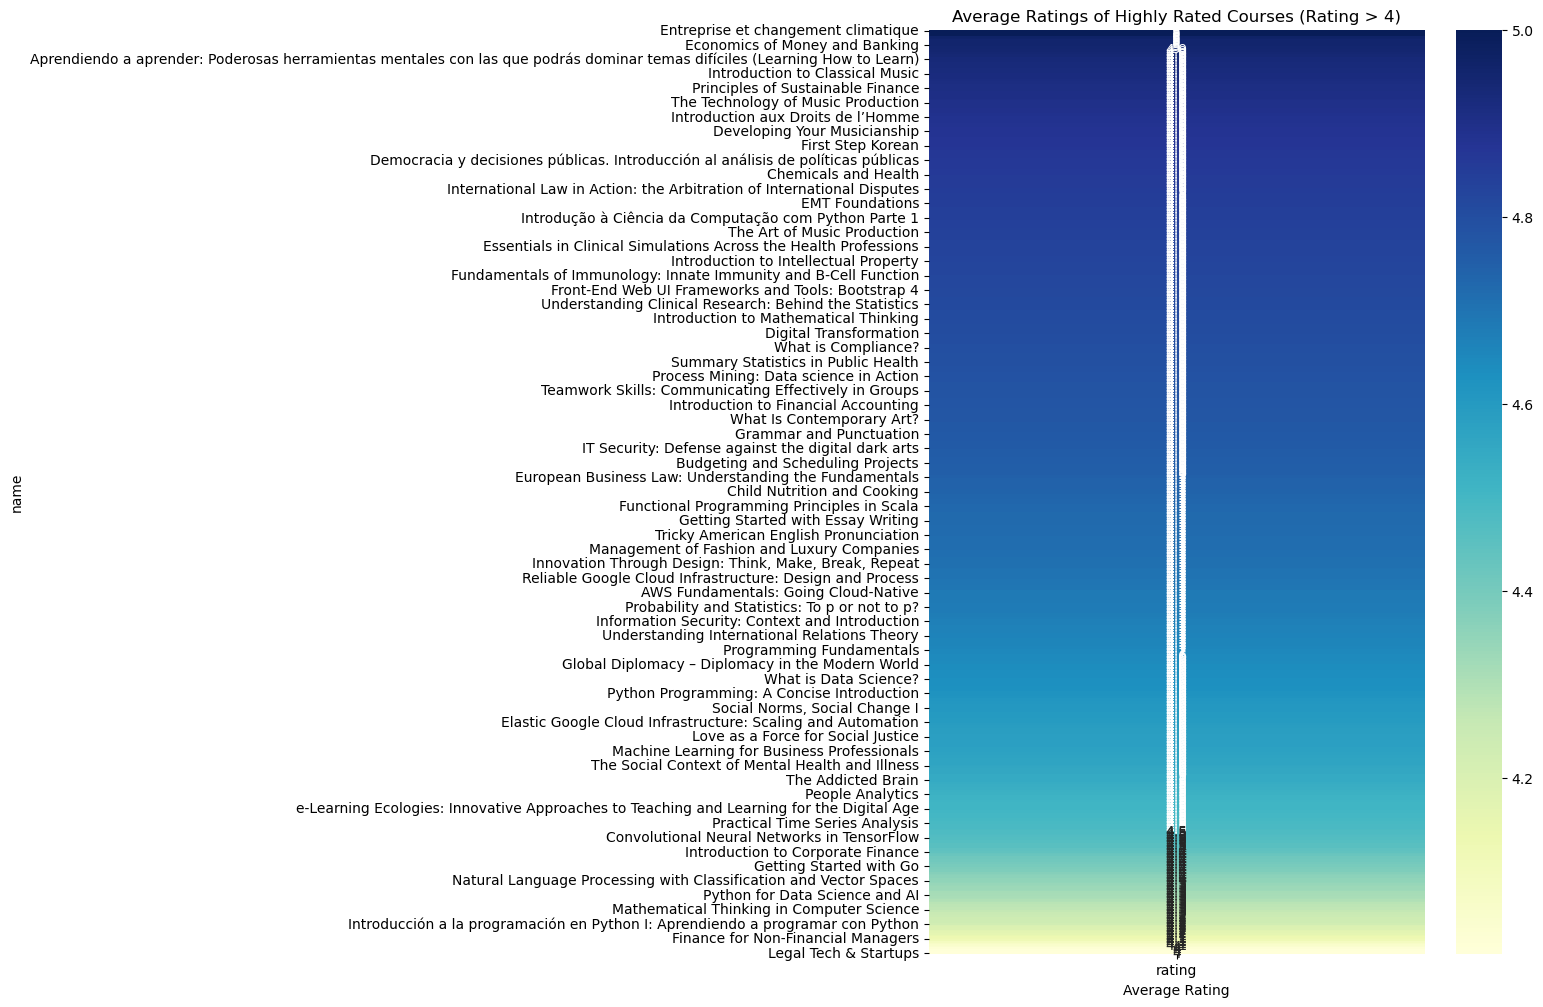

In [20]:
# Prepare data for heatmap
highly_rated_courses = course_ratings[course_ratings > 4].sort_values(ascending=False)
heatmap_data = pd.DataFrame(highly_rated_courses)

plt.figure(figsize=(8, 12))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True)
plt.title("Average Ratings of Highly Rated Courses (Rating > 4)")
plt.xlabel("Average Rating")
plt.show()